由于目标检测的数据集很大，所以这里沐神他们收集并标记了一个小型数据集 下载数据集

In [1]:
# 下面两行是防止内核挂掉加的
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

读取香蕉检测数据集：注意，下面的这个做法只能在小数据集上做，因为是把所有的图片都读到内存中了

In [2]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签。"""
    data_dir = d2l.download_extract('banana-detection')# 下载并解压
    csv_fname = os.path.join(data_dir,
                             'bananas_train' if is_train else 'bananas_val',
                             'label.csv') # 把.csv文件拿出来，.csv文件保存的信息是每张图片的标号：图片地址、物体标号、位置表示
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(
            torchvision.io.read_image( # 用torchvision把图片读到内存中
                os.path.join(data_dir,
                             'bananas_train' if is_train else 'bananas_val',
                             'images', f'{img_name}')))
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

创建一个自定义 Dataset 实例

In [3]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集。"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (
            f' training examples' if is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

为训练集和测试集返回两个数据加载器实例

In [4]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集。"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

读取一个小批量，并打印其中的图像和标签的形状。注意：图片和之前没区别（B, C, H, W）,但是标签有区别：第一个维度为batch size,第二个维度为设置的最大的物体类别（指一张图片中），第三个维度为：标签、对应的四个位置坐标，所以为5

In [5]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

示范

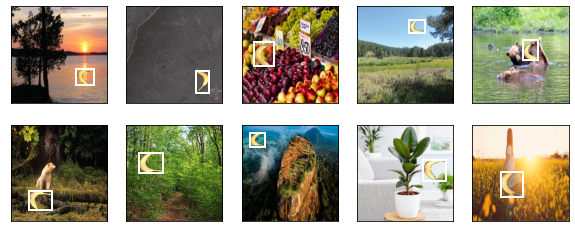

In [6]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])